# Last.fm Dataset

## Data Analysis based on the retrivied data. 

Based on the Last.fm API and with help of the pylast package, I got information about user, artists, tracks and tags. The code to generate the users and to get the data from the website are in ```scripts```. The data used here is generated in the Notebook ```last_api.ipynb```. In these scripts and notebook I used the the pyLast library, because it was built to connect with the Last.fm API. 

To generate a list of usernames, I visited the Last.fm webpage of several artists. But I considered three users randomly in the top listenings from three different coutries: Brazil, USA and United Kingdom. Using just this username, I generated additional Last.fm usernames using the user.getFriends method. With some loops, we can get the network (or part of it). It's possible to have some bias unknown yet.  

In [1]:
import pandas as pd 
import numpy as np 
import pylast

import os 
import json 

import matplotlib.pyplot as plt 
from matplotlib import ticker
import seaborn as sns 
sns.set()

from datetime import datetime

## Getting the generated data

The Last FM takes one song per time and it takes roughly 15s to retrive all information I wanted. Fot the tags and artists it requires less time. In this sense, I got only a subset of each object considered, cause I want only to undestand the data and it's behaviour. As I generated the users randomly, it's expected not to interfeer so much on the analysis. 

The Last.fm dataset won't be the main because of this initial problem of getting the data, but it's good to get some information I'll list below. 

The considered datasets are: 

- **Users**: information like gender, when he/her has registered, country, top artists, top tracks, etc. 
- **Tracks**: information about reaching, playcounts, similar tracks, top tags, etc. 
- **Artists**: information about number of listeners, top tracks, top albums, etc.
- **Tags**: information about registration, taggings, reaching, etc. This tags is done by user. 

In [2]:
FOLDER_PATH = '../data/lastfm-api/'

user_info_path = FOLDER_PATH + '1k_users_info_lastfm.json'
track_info_path = FOLDER_PATH + 'tracks_lastfm_info.json'
artist_info_path = FOLDER_PATH + 'artists_lastfm_info.json'
tag_info_path = FOLDER_PATH + 'tags_lastfm_info.json'

def get_random_users(filepath: str, quantity: int = 1000, random_state: int = 200) -> pd.DataFrame:
    
    users = pd.read_csv(filepath, index_col='user_id')
    chosen_users = users.sample(n = quantity, replace = False, random_state = random_state, axis = 'index')
    chosen_users.index = list(range(0,len(chosen_users)))

    return chosen_users

users_df = pd.read_csv(FOLDER_PATH + 'users_lastfm.csv', index_col='user_id')
track_df = pd.read_csv(FOLDER_PATH + 'tracks.csv', sep = '\t', index_col='track_id')
artist_df = pd.read_csv(FOLDER_PATH + 'artists.csv', sep = '\t', index_col='artist_id')
tag_df = pd.read_csv(FOLDER_PATH + 'tags.csv', sep = '\t', index_col='tag_id')

I import all the informations in dictionaries and considered the missing ones.

In [3]:
with open(user_info_path, 'r') as f:
    users_info = json.load(f)
with open(track_info_path, 'r') as f: 
    tracks_info = json.load(f)
with open(artist_info_path, 'r') as f:
    artists_info = json.load(f)
with open(tag_info_path, 'r') as f: 
    tags_info = json.load(f)    

for key, value in {'users': users_info, 'tracks': tracks_info, 'artists': artists_info, 'tags': tags_info}.items(): 
    print("Number of {}: {}".format(key, len(value)))
    print("Number of {} with no information: {}".format(key, 
          len({key for key in value.keys() if len(value[key]) == 0})))

Number of users: 1000
Number of users with no information: 1
Number of tracks: 9902
Number of tracks with no information: 311
Number of artists: 1055
Number of artists with no information: 0
Number of tags: 1843
Number of tags with no information: 4


## User Dataset

In [40]:
info = []

for key in users_info.keys():
    if len(users_info[key]) == 0:
        info.append([])
        continue
    c = users_info[key]['country'] 
    a = users_info[key]['age']
    s = int(users_info[key]['subscriber'])
    r = users_info[key]['registered_since']
    r = datetime.utcfromtimestamp(int(r))
    g = users_info[key]['gender']
    p = users_info[key]['playlists']
    pl = users_info[key]['playcount']

    info.append([int(key), c, a, s, r, g, p, pl])

info_df = pd.DataFrame(info, columns = ['user_id','country', 'age', 'subscriber', 
                                        'registered_since', 'gender', 'playlists', 'playcount'])

users_complete_df = users_df.merge(info_df, on = 'user_id')
users_complete_df.playcount = users_complete_df.playcount.astype(int)
users_complete_df.sample()

,user_id,user_name,country,age,subscriber,registered_since,gender,playlists,playcount
173,5264,CHARLIAOTY,United Kingdom,0.0,0.0,2020-02-03 20:23:07,n,0,14335


In [42]:
print('The information are: \n')
for i in users_info['22330'].keys():
    print(i)

The information are: 

name
subscriber
playcount
registered_since
country
age
playlists
gender
loved_tracks
recent_tracks
top_tracks
top_tags
top_albums
top_artists


I observe all the users considered don't insert age information neither gender. Create playlists in Last.fm is not a common thing too! I get the unique values in the three columns

In [43]:
print('Number of playlists: {}'.format(users_complete_df['playlists'].unique()))
print('Genders from the users: {}'.format(users_complete_df['gender'].unique()))
print('Age from the users: {}'.format(users_complete_df['age'].unique()))

Number of playlists: ['0']
Genders from the users: ['n']
Age from the users: [0.]


How many subscribers and how is the refistration distribution? 

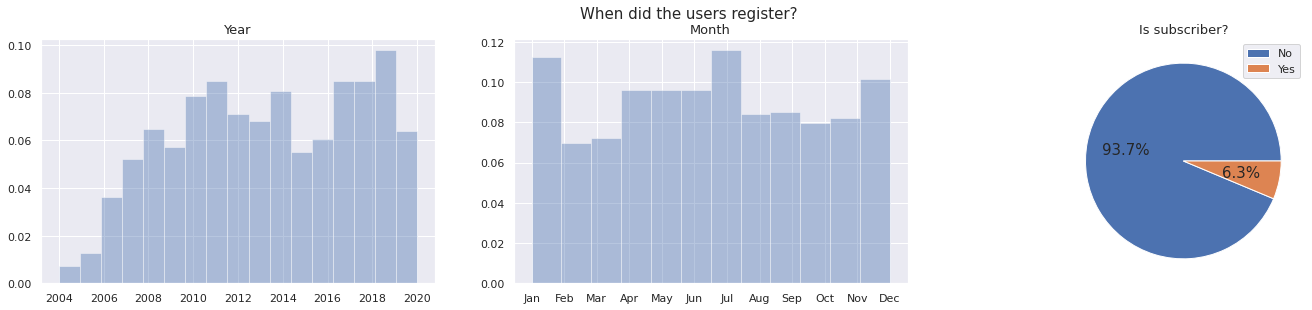

In [44]:
fig, ax = plt.subplots(1, 3, figsize = (24,4.5))
ax[2].pie(users_complete_df['subscriber'].value_counts(), labels = ['No', 'Yes'], labeldistance = None,
       autopct='%1.1f%%', textprops = {'fontsize': 15})
ax[2].set_title('Is subscriber?', fontsize = 13)
ax[2].legend()

years = [date.year for date in users_complete_df.registered_since]
months = [date.month for date in users_complete_df.registered_since]

sns.distplot(years, kde = False, bins = max(years) - min(years) + 1, norm_hist = True, ax = ax[0])
ax[0].set_title('Year', fontsize = 13)
sns.distplot(months, kde = False, bins = 12, norm_hist = True, ax = ax[1])
ax[1].set_title('Month', fontsize = 13)
ax[1].xaxis.set_major_locator(ticker.FixedLocator([1,2,3,4,5,6,7,8,9,10,11,12]))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
fig.suptitle('When did the users register?', fontsize = 15)

fig.savefig('../images/subscriber-registration.png')
plt.show()

In the following graphics: 

- For each $x \mapsto f(x)$ if $x$ people have listened to more than $f(x)$ tracks!

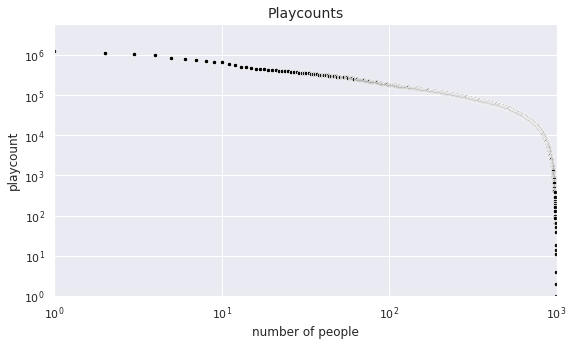

In [9]:
fig, ax = plt.subplots(figsize = (9,5))
ax.set(xscale = 'log', yscale = 'log', xlim = (1,1000), ylim = (1, 6000000))
sns.scatterplot(x = range(1, len(users_complete_df)+1), 
                y = users_complete_df.playcount.sort_values(ascending = False), s = 20, color = 'black')
ax.set_title('Playcounts', fontsize = 14)
ax.set_xlabel('number of people')
plt.show()

We can see the distribution of the countries in the sample. Brazil, USA and United Kingdom has clear advantage. 

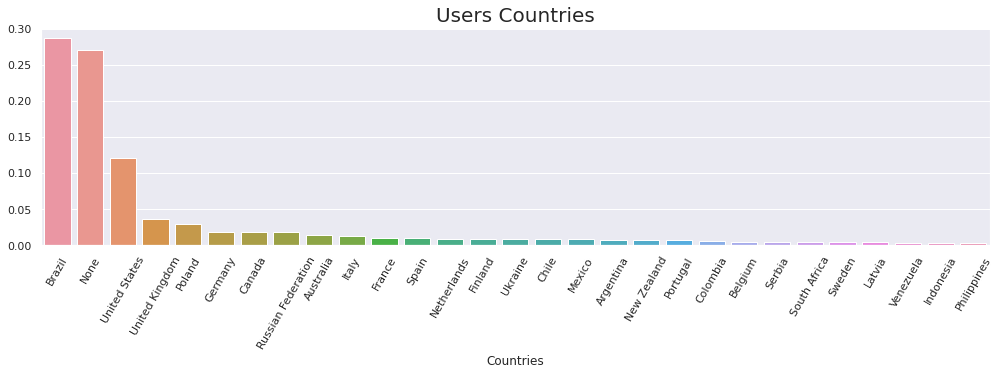

In [10]:
fig, ax = plt.subplots(figsize = (17,4))
countries_df = users_complete_df.country.value_counts(True)[users_complete_df.country.value_counts().values > 2] 
sns.barplot(x = countries_df.index, 
            y = countries_df.values, 
            ax = ax)
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 60)
ax.set_title('Users Countries', fontsize = 20)
ax.set_xlabel('Countries')
plt.show()

### Information of loved and top items

I separate the data from loved tracks for each user and I consider top tracks, artists and tags. The last three have an associated weight (counts of auditions of the object by the user). 

In [12]:
loved_tracks = []
top_tracks = []
top_artists = []
top_tags = []
for user_id in users_info.keys():
    if len(users_info[user_id]) == 0:
        continue
    loved_tracks.extend(users_info[user_id]['loved_tracks'])
    top_tracks.extend(users_info[user_id]['top_tracks'])
    top_artists.extend(users_info[user_id]['top_artists'])
    top_tags.extend(users_info[user_id]['top_tags'])

loved_tracks_count = {}
for loved in loved_tracks:
    if loved in loved_tracks_count:
        loved_tracks_count[loved] += 1
    else: loved_tracks_count[loved] = 1

top_tracks_count = {}
for top in top_tracks:
    if top[0] in top_tracks_count:
        top_tracks_count[top[0]] += 1
    else: top_tracks_count[top[0]] = 1

top_artists_count = {}
for top in top_artists:
    if top[0] in top_artists_count:
        top_artists_count[top[0]] += 1
    else: top_artists_count[top[0]] = 1

top_tags_count_weight = {}
for top in top_tags:
    if top[0] in top_tags_count_weight:
        top_tags_count_weight[top[0]] += int(top[1])
    else: top_tags_count_weight[top[0]] = int(top[1])

top_tags_count = {}
for top in top_tags:
    if top[0] in top_tags_count:
        top_tags_count[top[0]] += 1
    else: top_tags_count[top[0]] = 1

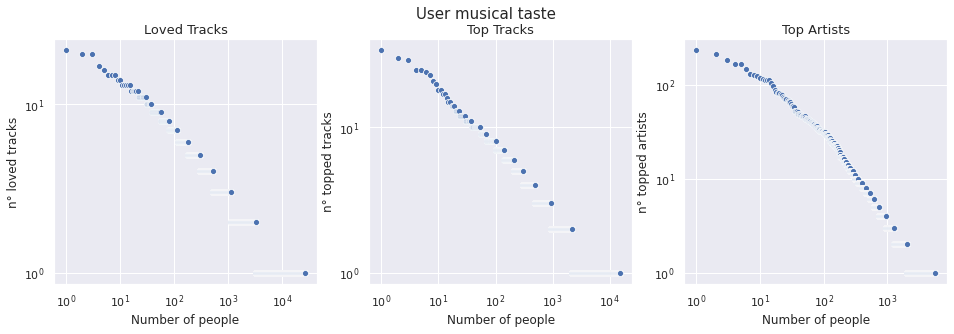

In [27]:
fig, ax = plt.subplots(1,3,figsize = (16,4.5))
sns.scatterplot(x = range(1,len(loved_tracks_count)+1), 
                y = sorted(loved_tracks_count.values(), reverse = True),
                ax = ax[0])
sns.scatterplot(x = range(1,len(top_tracks_count)+1), 
                y = sorted(top_tracks_count.values(), reverse = True),
                ax = ax[1])
sns.scatterplot(x = range(1,len(top_artists_count)+1), 
                y = sorted(top_artists_count.values(), reverse = True),
                ax = ax[2])
ax[0].set(xscale = 'log', yscale = 'log')
ax[0].set_title('Loved Tracks', fontsize = 13)
ax[0].set_ylabel('n° loved tracks')
ax[0].set_xlabel('Number of people')

ax[1].set(xscale = 'log', yscale = 'log')
ax[1].set_title('Top Tracks', fontsize = 13)
ax[1].set_ylabel('n° topped tracks')
ax[1].set_xlabel('Number of people')

ax[2].set(xscale = 'log', yscale = 'log')
ax[2].set_title('Top Artists', fontsize = 13)
ax[2].set_ylabel('n° topped artists')
ax[2].set_xlabel('Number of people')

fig.suptitle('User musical taste', fontsize = 15)

fig.savefig('../images/top-loved-tracks.png')
plt.show()

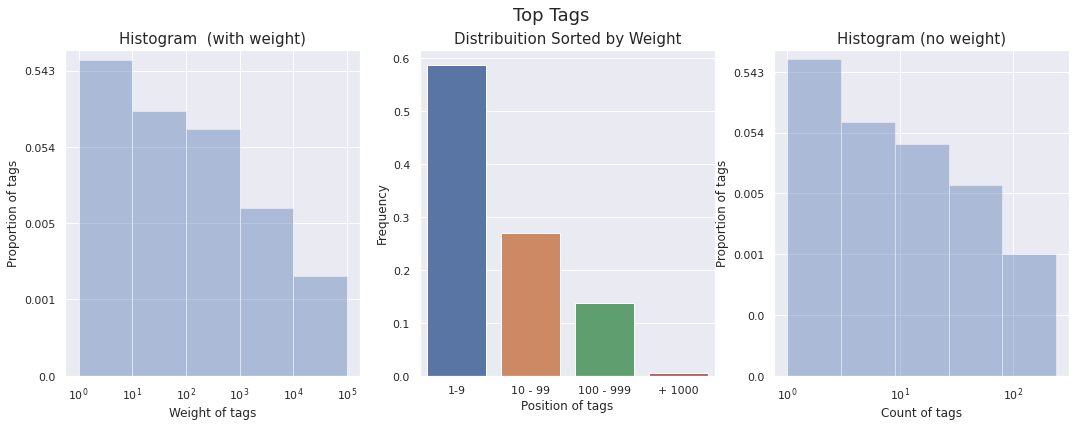

In [13]:
fig, ax = plt.subplots(1,3,figsize = (18,6))
sns.distplot(list(top_tags_count_weight.values()),
             bins = [1, 10, 100, 1000, 10000, 100000],
             kde = False, 
             norm_hist= False,
             ax = ax[0], 
             )
total = len(top_tags_count_weight.values())
ax[0].set(xscale = 'log', yscale = 'log')
ax[0].set_title('Histogram  (with weight)', fontsize = 15)
ax[0].set_ylabel('Proportion of tags')
ax[0].set_yticks([np.round(10**x, 3) for x in (-1,0,1,2,3)])
ax[0].set_yticklabels([np.round(10**x/total, 3) for x in (-1,0,1,2,3)])
ax[0].set_xlabel('Weight of tags')

percentages = np.flip(sorted(top_tags_count_weight.values()))/sum(top_tags_count_weight.values())
percentages = pd.DataFrame({10**b: sum(percentages[10**b - 1:10**(b+1) - 1]) for b in (0, 1, 2, 3)}, 
                        index = ['Percentage'])

sns.barplot(data = percentages, ax = ax[1])
ax[1].set_title('Distribuition Sorted by Weight', fontsize = 15)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Position of tags')
ax[1].set_xticks([0,1,2,3])
ax[1].set_xticklabels(['1-9', '10 - 99', '100 - 999', '+ 1000'])

sns.distplot(list(top_tags_count.values()),
             bins = [1, 3, 9, 27, 81, 243],
             kde = False, 
             norm_hist= False,
             ax = ax[2], 
             )
total = len(top_tags_count_weight.values())
ax[2].set(xscale = 'log', yscale = 'log')
ax[2].set_title('Histogram (no weight)', fontsize = 15)
ax[2].set_ylabel('Proportion of tags')
ax[2].set_yticks([np.round(10**x, 3) for x in (-2,-1,0,1,2,3)])
ax[2].set_yticklabels([np.round(10**x/total, 3) for x in (-2,-1,0,1,2,3)])
ax[2].set_xlabel('Count of tags')

fig.suptitle('Top Tags', fontsize = 18)

plt.show()

Considering the top tags for the users, we can get the 10 tags more used in general (weighted by the number of counts) and the 10 tags more used by individuals (no weight). 

In [14]:
top_tags_count_df = pd.DataFrame({'tag_id': list(top_tags_count_weight.keys()), 
                                         'weight_user': list(top_tags_count_weight.values()), 
                                         'users_listeners': list(top_tags_count.values())}
                                        )
tags = tag_df.merge(top_tags_count_df, on = 'tag_id')

display(tags.sort_values(by = 'weight_user', ascending = False).head(10))
display(tags.sort_values(by = 'users_listeners', ascending = False).head(10))

,tag_id,tag,weight_user,users_listeners
187,188,All,52112,2
217,218,spotify,45867,2
647,648,katarakt,4351,1
552,553,essentials,2836,1
648,649,scare the kids,2138,1
94,95,albums I own,1960,5
48,49,pop,1892,86
47,48,noise,1544,18
450,451,heavy metal,1502,9
649,650,ponyhof,1472,1


,tag_id,tag,weight_user,users_listeners
48,49,pop,1892,86
39,40,indie,667,72
49,50,rock,1425,72
67,68,electronic,845,67
50,51,alternative,753,61
105,106,experimental,889,48
59,60,female vocalists,1225,38
64,65,alternative rock,527,36
0,1,Hip-Hop,248,33
6,7,folk,283,32


## Tag Dataset

In [15]:
print('The information are: \n')
for i in tags_info['1'].keys():
    print(i)

The information are: 

name
reached
taggings
published
toptracks
topartists
topalbums


We can see the tags topped by tagging by the user.

In [16]:
reached = {int(key): tags_info[key]['reached'] for key in tags_info.keys() if len(tags_info[key]) > 0}
tagging = {int(key): tags_info[key]['taggings'] for key in tags_info.keys() if len(tags_info[key]) > 0}
published = {int(key): tags_info[key]['published'] for key in tags_info.keys() if len(tags_info[key]) > 0}
tags_extra_info = pd.DataFrame({'tag_id': list(reached.keys()), 
                             'tag_reached': list(reached.values()), 
                             'taggings': list(tagging.values()), 
                             'published': list(published.values())})

tags_complete_df = tag_df.merge(tags_extra_info, on = 'tag_id')
tags_complete_df.sort_values(by = 'taggings', ascending = False, inplace = True)
tags_complete_df.head(5)

,tag_id,tag,tag_reached,taggings,published
49,50,rock,395583,3979593,None
67,68,electronic,254123,2371259,None
73,74,seen live,81737,2142301,None
50,51,alternative,261864,2095454,None
39,40,indie,253561,2017410,None


None information about publishing is provided. Other columns are complete.

In [17]:
display(tags_complete_df.info())
display(tags_complete_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 49 to 1062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tag_id       1839 non-null   int64 
 1   tag          1839 non-null   object
 2   tag_reached  1839 non-null   int64 
 3   taggings     1839 non-null   int64 
 4   published    0 non-null      object
dtypes: int64(3), object(2)
memory usage: 86.2+ KB


None

,tag_id,tag_reached,taggings
count,1839.000000,1839.000000,1.839000e+03
mean,921.706362,7487.895052,4.825904e+04
std,532.714042,23491.221844,1.907456e+05
min,1.000000,0.000000,0.000000e+00
25%,460.500000,15.000000,4.800000e+01
50%,920.000000,448.000000,1.875000e+03
75%,1383.500000,4023.500000,1.936600e+04
max,1843.000000,395583.000000,3.979593e+06


## Artist Dataset

In [18]:
print('The information are: \n')
for i in artists_info['1'].keys():
    print(i)

The information are: 

name
listeners
plays
published
topalbums
toptags
toptracks
similar


In [15]:
info = []

for key in artists_info.keys():
    if len(artists_info[key]) == 0:
        info.append([])
        continue
    l = artists_info[key]['listeners'] 
    p = artists_info[key]['plays']
    pu = artists_info[key]['published']

    info.append([int(key), l, p, pu])

info_df = pd.DataFrame(info, columns = ['artist_id','listeners', 'plays', 'published'])

artists_complete_df = artist_df.merge(info_df, on = 'artist_id')
artists_complete_df.sort_values(by = 'listeners', ascending = False).head(10)

artists_complete_df['year'] = artists_complete_df['published'].apply(lambda x: int(x[0:4]) if x else None)

In [16]:
display(artists_complete_df.info())
display(artists_complete_df[['listeners', 'plays']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055 entries, 0 to 1054
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   artist_id    1055 non-null   int64  
 1   artist_name  1055 non-null   object 
 2   listeners    1055 non-null   int64  
 3   plays        1055 non-null   int64  
 4   published    1054 non-null   object 
 5   year         1054 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 57.7+ KB


None

,listeners,plays
count,1.055000e+03,1.055000e+03
mean,7.618084e+05,3.413387e+07
std,9.753264e+05,5.775166e+07
min,0.000000e+00,0.000000e+00
25%,9.122600e+04,3.136608e+06
50%,3.468340e+05,1.252607e+07
75%,1.010848e+06,3.625391e+07
max,5.575436e+06,5.541699e+08


We can see that there artists published before 2000, what it's wrong information. (28 artists actually)

In [17]:
artists_complete_df[artists_complete_df.year < 2000].shape

(28, 6)

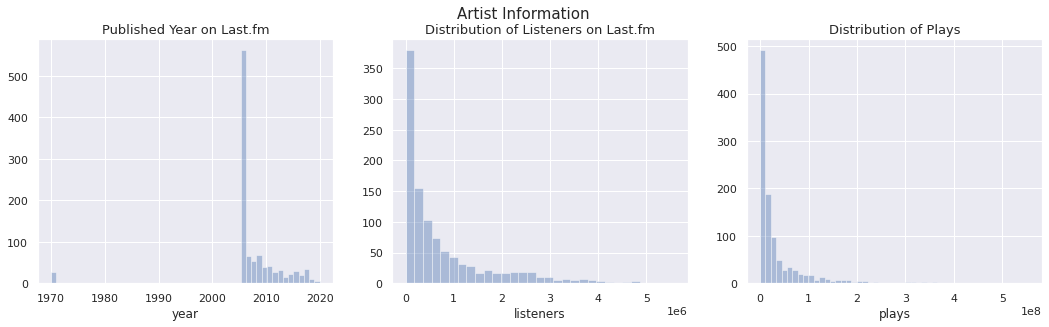

In [26]:
fig, ax = plt.subplots(1,3, figsize = (18, 4.5))
sns.distplot(artists_complete_df.year, kde = False, 
            bins = int(artists_complete_df.year.max() - artists_complete_df.year.min()) + 1,
            ax = ax[0])
ax[0].set_title('Published Year on Last.fm', fontsize = 13)
sns.distplot(artists_complete_df.listeners, kde = False, 
            #bins = int(artists_complete_df.year.max() - artists_complete_df.year.min()) + 1,
            ax = ax[1])
ax[1].set_title('Distribution of Listeners on Last.fm', fontsize = 13)
sns.distplot(artists_complete_df.plays, kde = False, 
            #bins = int(artists_complete_df.year.max() - artists_complete_df.year.min()) + 1,
            ax = ax[2])
ax[2].set_title('Distribution of Plays', fontsize = 13)
fig.suptitle('Artist Information', fontsize = 15)

fig.savefig('../images/artist_info.png')
plt.show()

## Artists Similarity

Last.fm API has information about similar artists, given an artist imputed. I generate 20 similar artists from each artist of the subset of artists known from the dataset. The method of the API returns a degree of similarity, from 0 to 1. Below we can see de result. It takes long to make this graphic, so I save it. You can see the result. There are a lot of nan values because we do not have every degree of similary. 

We can see there are a bigger relation in the roundness of the diagonal. This happens because the way the artist id was generated. For each user, we get its 20 top artists and numerate if the id does not exist. So, if two ids are closely, maybe it was generated by the same user, what is interesting, cause users may like similar artists.  

In [23]:
max_artist_id = 0
for key, value in artists_info.items():
    for index in value['similar']:
        if index[0] > max_artist_id: 
            max_artist_id = index[0]

artist_matrix_similarity = np.empty(shape = (max_artist_id, max_artist_id))
artist_matrix_similarity.fill(np.nan)
for key, value in artists_info.items():
    for index in value['similar']:
        artist_matrix_similarity[int(key) - 1, index[0] - 1] = index[1]

In [24]:
#fig, ax = plt.subplots(figsize = (11,9))
#sns.heatmap(artist_matrix_similarity[0:1000, 0:1000], vmin = 0, vmax = 1, cmap = 'YlGnBu', 
#                 cbar_kws = {'orientation': 'horizontal'})

#fig.savefig('heatmap.png')
#plt.show()

### Subset of Artists Similary 

![Figura](../images/heatmap.png)

## Track Dataset

In [25]:
print('The information are: \n')
for i in tracks_info['1'].keys():
    print(i)

The information are: 

name
artist
duration
listeners
playcount
album
published
top_tags
similar


In [26]:
info = []

for key in tracks_info.keys():
    if len(tracks_info[key]) == 0:
        info.append([])
        continue
    d = tracks_info[key]['duration'] 
    l = tracks_info[key]['listeners']
    p = tracks_info[key]['playcount']
    pu = tracks_info[key]['published']
    tags = tracks_info[key]['top_tags']

    info.append([int(key), int(d), int(l), int(p), pu])

info_df = pd.DataFrame(info, columns = ['track_id', 'duration', 'listeners', 'playcount', 'published'])

tracks_complete_df = track_df.merge(info_df, on = 'track_id')
tracks_complete_df['year'] = tracks_complete_df['published'].apply(lambda x: int(x[0:4]) if x else None)
tracks_complete_df.sample()

,track_id,artist_name,track_name,duration,listeners,playcount,published,year
2435,2496,21 Savage,all my friends,211000.0,69754.0,483699.0,None,NaN


We can see that published information is unavailable for a lot of tracks

In [27]:
display(tracks_complete_df.info())
display(tracks_complete_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9591 entries, 0 to 9590
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   track_id     9591 non-null   int64  
 1   artist_name  9591 non-null   object 
 2   track_name   9591 non-null   object 
 3   duration     9591 non-null   float64
 4   listeners    9591 non-null   float64
 5   playcount    9591 non-null   float64
 6   published    2087 non-null   object 
 7   year         2087 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 674.4+ KB


None

,track_id,duration,listeners,playcount,year
count,9591.000000,9.591000e+03,9.591000e+03,9.591000e+03,2087.000000
mean,4933.992389,2.095320e+05,1.156337e+05,8.723463e+05,2012.651174
std,2864.438821,1.349446e+05,2.069033e+05,1.744338e+06,4.101426
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,2008.000000
25%,2457.500000,1.640000e+05,5.903500e+03,2.799300e+04,2009.000000
50%,4921.000000,2.150000e+05,3.330400e+04,1.978630e+05,2012.000000
75%,7419.500000,2.630000e+05,1.262990e+05,8.853590e+05,2017.000000
max,9902.000000,3.422000e+06,2.179201e+06,2.784013e+07,2020.000000


### Artists Library for 50 Users

We collect all the artists listen by a user and we build a matrix that the cel $ij$ is the number of playcounts of the user $j+1$ to the artist $i$ 

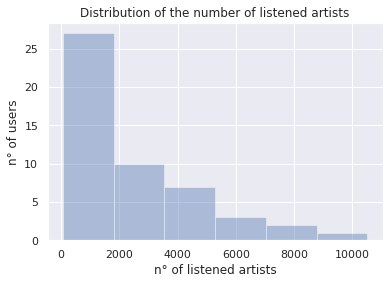

In [28]:
with open('../data/lastfm-api/users50_library.json', 'r') as f:
    users50_library = json.load(f)

max_artist_id = 0
number_artists = []
for key, value in users50_library.items():
    number_artists.append(len(value))
    for artist in value:
        if int(artist) > max_artist_id:
            max_artist_id = int(artist)

ax = sns.distplot(number_artists, kde = False)
ax.set_title('Distribution of the number of listened artists')
ax.set_xlabel('n° of listened artists')
ax.set_ylabel('n° of users')
plt.show()

In [29]:
users50_library_array = np.zeros(shape = (max_artist_id, 50))
for index, key in enumerate(users50_library):
    for key_artist, value in users50_library[key].items():
        users50_library_array[int(key_artist) - 1, index] = int(value) 
users50_library_df = pd.DataFrame(users50_library_array, index = range(1, len(users50_library_array) + 1), dtype = int)

Below we see the the rows ordered by their sum. 

In [30]:
q = users50_library_df.loc[users50_library_df.sum(axis = 1).sort_values(ascending = False).index]
display(q.head())

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
479,0,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,13,0,0,0,21
4,991,955,15,749,0,0,367,1,0,478,...,50,204,167,552,428,587,2,1,16,74
79,62,1,110,0,591,0,2,45,10,1365,...,12,0,2,90,13,93,0,811,0,1944
3,1043,39,498,0,3618,0,0,5,0,324,...,353,0,930,422,459,537,396,360,4,903
7,459,84,0,1482,0,0,0,2,1,212,...,0,10,29,32,433,545,0,4,1,69


The corresponded artists. 

In [31]:
artist_df.loc[q.head().index]

,artist_name
479,Gloria Groove
4,Radiohead
79,Lady Gaga
3,Lana Del Rey
7,The Beatles


## Baseline model

In [50]:
FOLDER_SPOTIFY_PATH = '../data/'

playlists_df = pd.read_pickle(FOLDER_SPOTIFY_PATH + 'sp_playlists.pkl')
playlists_df.tracks.loc[0]

{'href': 'https://api.spotify.com/v1/playlists/2Jk9vYEHZcwSOQ5aQXnuya/tracks',
 'total': 2}

## Conclusion 

There are lot more information we could retrive, but we considered only a part of it, to test the initial models. It's a good API, but to get the links, it's really slow, what harms the Data Science pipelines. There is datasets already done with part of this information, but we prefered to generate cause it's more trustable and everyone can generate it. But remember it can take a long time. 